In [3]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.random.set_seed(123)
import os, shutil
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import keras



In [16]:
!pip install tensorflow==2.3.1

In [18]:
tf.__version__

'2.3.0'

In [19]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /opt/anaconda3/lib/python3.7/site-packages (2.3.1)


### Generator

In [6]:
# Directory path
train_data_dir = 'Data/chest_xray/train'
test_data_dir = 'Data/chest_xray/test'
val_data_dir = 'Data/chest_xray/val'

# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), class_mode='binary')

# Get all the data in the directory data/train (5232 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), class_mode='binary')

# Validation Generator:
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_data_dir, 
        target_size=(256, 256), class_mode='binary')


Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


NameError: name 'train_images' is not defined

In [63]:
train_generator.class_indices


{'NORMAL': 0, 'PNEUMONIA': 1}

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy', 'Recall', 'Precision'])

In [12]:
history = model.fit(train_generator, 
                    epochs=10, 
                    validation_data = val_generator,
                   )

Epoch 1/10


UnimplementedError:  Fused conv implementation does not support grouped convolutions for now.
	 [[node sequential_1/conv2d_2/Relu (defined at <ipython-input-12-ff5d0f7e2dcb>:3) ]] [Op:__inference_train_function_1480]

Function call stack:
train_function


### Fixing the labels

In [66]:
# fix the labels for the images so that normal=0 and pneumonia=1
y_model = train_labels.T[[1]]
y_test = test_labels.T[[1]]

In [67]:
y_model, y_model.shape

(array([[1., 1., 1., ..., 1., 1., 1.]], dtype=float32), (1, 5232))

In [68]:
# counts for each class
print('Train Class Counts:', np.unique(y_model, return_counts=True))
print('Test Class Counts:', np.unique(y_test, return_counts=True))

Train Class Counts: (array([0., 1.], dtype=float32), array([1349, 3883]))
Test Class Counts: (array([0., 1.], dtype=float32), array([234, 390]))


In [69]:
y_model = y_model.T
y_test = y_test.T

In [70]:
test_images.shape

(624, 256, 256, 3)

### Reshape and standardize images

In [71]:
# reshape the images
train_img_unrow = train_images.reshape(5232, -1)
test_img_unrow = test_images.reshape(624, -1)

In [72]:
test_img_unrow.shape

(624, 196608)

In [73]:
train_img_unrow, train_img_unrow

(array([[83., 83., 83., ..., 22., 22., 22.],
        [ 2.,  2.,  2., ...,  0.,  0.,  0.],
        [67., 67., 67., ...,  4.,  4.,  4.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [35., 35., 35., ..., 22., 22., 22.],
        [36., 36., 36., ..., 19., 19., 19.]], dtype=float32),
 array([[83., 83., 83., ..., 22., 22., 22.],
        [ 2.,  2.,  2., ...,  0.,  0.,  0.],
        [67., 67., 67., ...,  4.,  4.,  4.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [35., 35., 35., ..., 22., 22., 22.],
        [36., 36., 36., ..., 19., 19., 19.]], dtype=float32))

In [74]:
# standardize data
X_model = train_img_unrow/255
X_test = test_img_unrow/255

In [75]:
X_model.shape, X_test.shape

((5232, 196608), (624, 196608))

### Model building:

#### Model # 1

In [76]:
# split model set into training and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.2, random_state=123)

In [77]:
# function for visualizing loss and accuracy across epochs for training and validation set
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_recall'])
    plt.plot(history['recall'])
    plt.legend(['val_recall', 'recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

In [78]:
model_1 = Sequential()
model_1.add(layers.Dense(128, activation='tanh', input_shape=(196608,)))
model_1.add(layers.Dense(64, activation='tanh'))
model_1.add(layers.Dense(32, activation='tanh'))
model_1.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model_1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy', keras.metrics.Recall()])


In [21]:
results_1 = model_1.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/10
66/66 [==============================] - 11s 162ms/step - loss: 0.6797 - accuracy: 0.6648 - recall: 0.8480 - val_loss: 0.5543 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 2/10
66/66 [==============================] - 8s 122ms/step - loss: 0.5365 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.5576 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 3/10
66/66 [==============================] - 8s 121ms/step - loss: 0.5371 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.4729 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 4/10
66/66 [==============================] - 7s 113ms/step - loss: 0.4840 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.5154 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 5/10
66/66 [==============================] - 8s 116ms/step - loss: 0.4634 - accuracy: 0.7668 - recall: 0.9936 - val_loss: 0.4634 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 6/10
66/66 [==============================] - 8s 115ms/step - loss: 0.4197 - accuracy: 0.8096

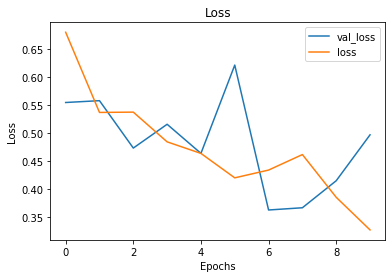

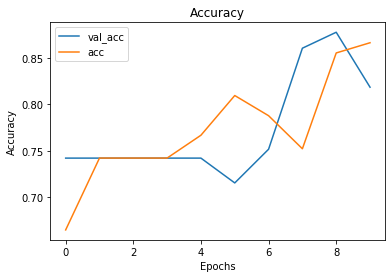

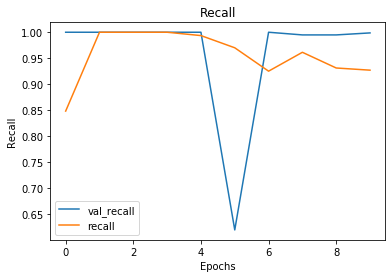

In [22]:
# change in loss and accuracy for training and validation set per epoch
visualize_training_results(results_1)


In [23]:
# evaluate training and test sets
results_train = model_1.evaluate(X_train, y_train)
results_test = model_1.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 1s 28ms/step - loss: 0.9568 - accuracy: 0.6651 - recall: 1.0000
[0.5077478885650635, 0.8112305998802185, 0.9987121820449829] [0.9567636251449585, 0.6650640964508057, 1.0]


#### Model #2

In [79]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=624)

# Get all the data in the directory data/train (5232 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [80]:
train_labels.shape

(5232, 2)

In [81]:
test_labels.shape

(624, 2)

In [82]:
train_labels = np.reshape(train_labels[:,1], (5232,1))


In [83]:
test_labels = np.reshape(test_labels[:,1], (624,1))

In [84]:
train_labels.shape, test_labels.shape

((5232, 1), (624, 1))

In [85]:
y_train.shape

(4185, 1)

In [86]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.20, random_state=123)

In [87]:
#y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
#y_val = np.asarray(test_labels).astype('float32').reshape((-1,1))

In [88]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer = "Adam",
              metrics=['accuracy', 'Recall'])

In [89]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=50,
                    validation_data=(X_val, y_val),
                      workers = -1)

Epoch 1/10
37/84 [============>.................] - ETA: 1:54 - loss: 0.5970 - accuracy: 0.7719 - recall: 0.8942

KeyboardInterrupt: 

In [ ]:
visualize_training_results(cnn1)


In [ ]:
## Test set:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(test_images, y_test)
print(results_train, results_test) ## loss, accuracy, recall

It seems like our model is doing well in the training set but not as well in the test set. I can see overfitting I wil l try to add more complexitiy  

In [38]:
# How to improve our model?
# How to deal with class imbalance ? (data augmentation vs downsample/upsample)

## baseline model - during preprocessing before resampling
## DROP OUT, lasso-ridge, augment images (throw away)

### 2nd CNN Model:

In [58]:
cnn_2 = models.Sequential()
cnn_2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn_2.add(layers.MaxPooling2D((2, 2)))
cnn_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_2.add(layers.MaxPooling2D((2, 2)))
cnn_2.add(layers.Conv2D(64, (3, 3), activation='selu', input_shape=(256, 256,  3)))
cnn_2.add(layers.MaxPooling2D((2, 2)))
cnn_2.add(layers.Flatten())
cnn_2.add(layers.Dense(32, activation='relu'))
cnn_2.add(layers.Dense(1, activation='sigmoid'))

cnn_2.compile(loss='binary_crossentropy',
              optimizer = "Adam",
              metrics=['accuracy', 'Recall'])

In [59]:
cnn2 = cnn_2.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=50,
                    validation_data=(X_val, y_val),
                      workers = -1)

ValueError: Data cardinality is ambiguous:
  x sizes: 12555
  y sizes: 4185
Please provide data which shares the same first dimension.

In [60]:
results_train = cnn_2.evaluate(X_train, y_train)
results_test = cnn_2.evaluate(test_images, y_test)
print(results_train, results_test) ## loss, accuracy, recall

ValueError: Data cardinality is ambiguous:
  x sizes: 12555
  y sizes: 4185
Please provide data which shares the same first dimension.

In [42]:
cnn2.history

{'loss': [0.31237325072288513,
  0.10924725979566574,
  0.14016737043857574,
  0.07755190134048462,
  0.06876557320356369,
  0.05887214466929436,
  0.05349935591220856,
  0.05133765935897827,
  0.031190820038318634,
  0.030013596639037132],
 'acc': [0.8518518805503845,
  0.959378719329834,
  0.9459975957870483,
  0.9698925018310547,
  0.9739546179771423,
  0.9784946441650391,
  0.9811230301856995,
  0.9801672697067261,
  0.9894862771034241,
  0.9892473220825195],
 'recall_1': [0.9226555228233337,
  0.9732517004013062,
  0.9645504355430603,
  0.9803416132926941,
  0.9829197525978088,
  0.9845311045646667,
  0.9854978919029236,
  0.9871092438697815,
  0.9919432997703552,
  0.9932323694229126],
 'val_loss': [0.12760815024375916,
  0.08792846649885178,
  0.09272534400224686,
  0.1395934522151947,
  0.09278327226638794,
  0.08432161808013916,
  0.1914723962545395,
  0.08545460551977158,
  0.08202410489320755,
  0.09830896556377411],
 'val_acc': [0.9570200443267822,
  0.9694364666938782,
  0

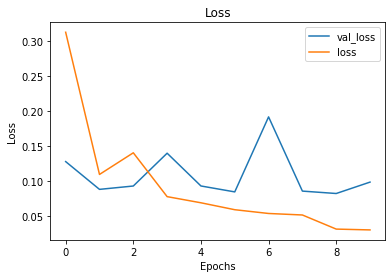

KeyError: 'val_accuracy'

<Figure size 432x288 with 0 Axes>

In [43]:
visualize_training_results(cnn2)


### Model #3:

In [ ]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Model 4: Adding Data Augmentation

In [44]:
train_generator_aug = ImageDataGenerator(rescale = 1./255,
                                         brightness_range = [0.8, 1.2],
                                         shear_range=5,
                                         zoom_range = 0.2,
                                         horizontal_flip=True)

train_generator_aug = train_generator_aug.flow_from_directory(train_data_dir,
                                              target_size = (256,256), 
                                              color_mode='grayscale',
                                              class_mode='binary')
train_images, train_labels = next(train_generator_aug)
test_images, test_labels = next(test_generator)

Found 5232 images belonging to 2 classes.


In [49]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [52]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy', 'Recall'])

In [56]:
history = model_aug.fit(X_train,
                    y_train,
                    epochs=10, 
                    validation_data = (X_val, y_val),
                    workers = -1,  
                    verbose = 2
                   )

ValueError: Data cardinality is ambiguous:
  x sizes: 12555
  y sizes: 4185
Please provide data which shares the same first dimension.

(12555, 256, 256, 1)